# Shallow Embedding Methods

Shallow embedding methods refer to a category of algorithms that generate fixed, static vector representations for the input data, typically **without involving deep learning architectures or dynamic updates** during downstream tasks.

## Matrix Factorization

Matrix factorization is a broadly applicable decomposition technique used across various fields. In the context of graph embedding, it serves as a foundational method for deriving low-dimensional node representations from a graph’s structure.

Several graph embedding techniques leverage matrix factorization to capture structural properties. In this section, we introduce two prominent algorithms:

- **Graph Factorization (GF)**
- **Higher-Order Proximity preserved Embedding (HOPE)**

Both approaches use matrix factorization to compute node embeddings that preserve different aspects of the graph’s topology.


Let $W \in \mathbb{R}^{m \times n}$ represent the input data matrix. Matrix factorization aims to approximate this matrix as the product of two lower-dimensional matrices:  
$W \approx V \times H$  
where $V \in \mathbb{R}^{m \times d}$ and $H \in \mathbb{R}^{d \times n}$ are referred to as the **source** and **abundance** matrices, respectively. The parameter $d$ indicates the dimensionality of the embedding space.  

The matrix factorization process involves learning $V$ and $H$ by minimizing a loss function, typically defined as the reconstruction error. A commonly used form is the Frobenius norm:  
$\left\| W - V \times H \right\|_F^2$  

This fundamental approach underlies many unsupervised graph embedding methods. These techniques represent the input graph as a matrix (such as an adjacency or proximity matrix) and decompose it to capture structural relationships. While the core principle is consistent across different models, they differ in how the loss function is defined. Different loss formulations allow the learned embedding space to highlight specific properties of the graph structure.


In [6]:
import matplotlib.pyplot as plt

def draw_graph(G, node_names={}, node_size=500):
    pos_nodes = nx.spring_layout(G)
    nx.draw(G, pos_nodes, with_labels=True, node_size=node_size, edge_color='gray', arrowsize=30)
    
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
    #nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)
    
    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.show()

## Graph Factorization

Graph Factorization (GF) was among the earliest models designed to efficiently compute node embeddings for a given graph. It follows the general matrix factorization principle described earlier, and specifically factorizes the adjacency matrix of the graph.

Formally, let $G = (V, E)$ be the input graph, and let $A \in \mathbb{R}^{|V| \times |V|}$ denote its adjacency matrix. The GF algorithm aims to learn a low-dimensional embedding matrix $Y \in \mathbb{R}^{|V| \times d}$, where each row $Y_{i,:}$ corresponds to the $d$-dimensional embedding of node $i$.

The loss function used in GF is defined as:

$$
L = \frac{1}{2} \sum_{(i,j)\in E} \left(A_{i,j} - Y_{i,:} Y_{j,:}^\top \right)^2 
+ \frac{\lambda}{2} \sum_i \left\| Y_{i,:} \right\|^2
$$

Here, $(i, j) \in E$ indicates an edge in the graph, and $\lambda$ is a regularization coefficient that helps prevent overfitting and ensures the stability of the optimization, especially in sparse graphs.

The first term in the loss measures the reconstruction error between the actual adjacency values and the inner product of the corresponding node embeddings. The second term penalizes large embedding values to control model complexity.


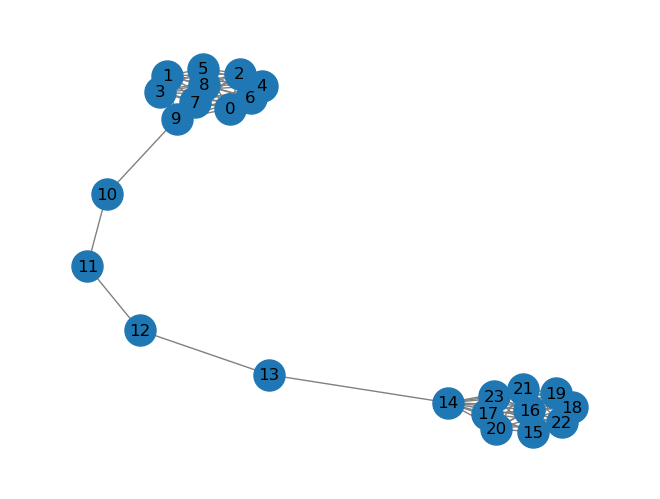

In [2]:
import networkx as nx

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)


In [7]:
#!pip install git+https://github.com/palash1992/GEM.git

In [3]:
from pathlib import Path
Path("gem/intermediate").mkdir(parents=True, exist_ok=True)

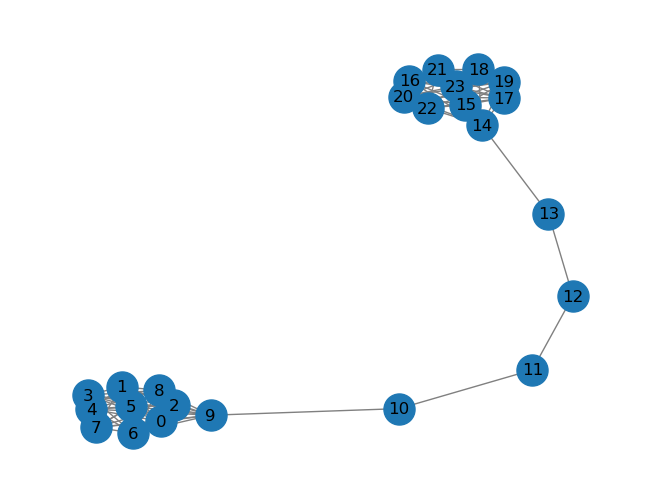

./gf not found. Reverting to Python implementation. Please compile gf, place node2vec in the path and grant executable permission


array([[-0.00296322, -0.00289538],
       [-0.00296152, -0.00289598],
       [-0.00296458, -0.00289446],
       [-0.00296274, -0.00289869],
       [-0.00294662, -0.00289779],
       [-0.00307019, -0.00283455],
       [-0.00228408, -0.0028019 ],
       [-0.00461994, -0.00395802],
       [-0.00225683, -0.00198374],
       [-0.00738909, -0.00340902],
       [-0.01505051, -0.0060095 ],
       [-0.00835906, -0.00617471],
       [ 0.00022253, -0.00377277],
       [ 0.00280522,  0.00319865],
       [ 0.00862428, -0.00179457],
       [ 0.00862761, -0.00179438],
       [ 0.00862094, -0.00179564],
       [ 0.00861799, -0.0017991 ],
       [ 0.00864409, -0.00180069],
       [ 0.00868223, -0.00168469],
       [ 0.00881149, -0.00196443],
       [ 0.008113  , -0.00299607],
       [ 0.00644314, -0.00215713],
       [ 0.01149144,  0.00318054]])

In [4]:
#Instead of this old library, we use newer one
from gem.embedding.gf import GraphFactorization

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

gf = GraphFactorization(d=2,  data_set=None,max_iter=10000, eta=1*10**-4, regu=1.0)
gf.learn_embedding(G)

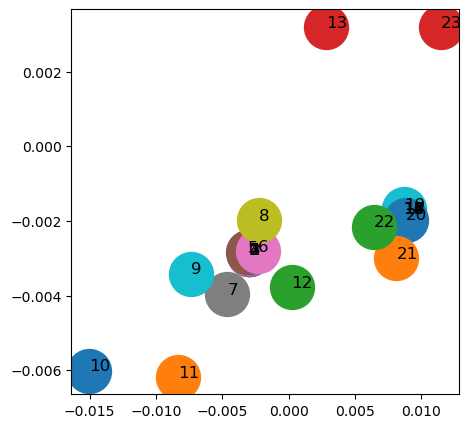

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))

for x in G.nodes():
    
    v = gf.get_embedding()[x]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=12)

# Graph Representation with Global Structure Information (GraphRep)

GraphRep is a family of graph embedding methods that preserve **global structural information**. A well-known example is **HOPE (High-Order Proximity preserved Embedding)**, which captures **higher-order node proximity** without requiring embeddings to be symmetric.

## Motivation

Most basic embedding methods capture only first-order (direct links) or second-order (shared neighbors) proximities. However, **global proximity** (longer-range relationships between nodes) often reveals richer structure. GraphRep methods address this by considering multiple steps (orders) of proximity in the graph.

---

## Notation and Setup

Let:

- $ G = (V, E) $: input graph with $ |V| $ nodes  
- $ A \in \mathbb{R}^{|V| \times |V|} $: adjacency matrix  
- $ D $: diagonal **degree matrix**, defined as:

  $$
  D_{ij} =
  \begin{cases}
  \sum_p A_{ip}, & \text{if } i = j \\
  0, & \text{otherwise}
  \end{cases}
  $$

- $ X^k \in \mathbb{R}^{|V| \times |V| }$: the **k-th order proximity matrix**  
- $ Y_s^k, Y_t^k \in \mathbb{R}^{|V| \times d} $: embedding matrices for source and target nodes  
- $ d $: dimension of embeddings per proximity order  
- $ K $: maximum order of proximity  

---

## What is the $ k $th-Order Proximity?

The **$ k $th-order proximity** measures how strongly two nodes are connected by walks of length $ k $. It is calculated using the **transition probability matrix**:

- First-order transition matrix:
  $
  X^1 = D^{-1} A
  $
  where $ X^1_{ij} $ gives the probability of moving from node $ v_i $ to $ v_j $ in one step.

- Higher-order transition matrix:
  $
  X^k = (D^{-1} A)^k
  $
  where $ X^k_{ij} $ is the probability of moving from $ v_i $ to $ v_j $ in exactly $ k $ steps.

---

## Objective Function

For each proximity order $ k $, the loss function is defined as:

$
L_k = \left\| X^k - Y_s^k \cdot \left(Y_t^k\right)^{T} \right\|_F^2 \quad \text{for } 1 \leq k \leq K
$

- $ \|\cdot\|_F $ is the **Frobenius norm**  
- This loss measures how well the embedding matrices approximate the proximity matrix $ X^k $

Each $ L_k $ is minimized **independently** to learn the embedding matrices $ Y_s^k $ and $ Y_t^k $.

---

## Final Embedding Construction

After optimization, the final embedding for each node is constructed by **concatenating** the source embeddings from all orders:

$
Y_s = \left[ Y_s^1 \ \| \ Y_s^2 \ \| \ \cdots \ \| \ Y_s^K \right] \in \mathbb{R}^{|V| \times (d \cdot K)}
$

- **Number of rows**: $ |V| $ (one per node)  
- **Number of columns**: $ d \cdot K$

This way, each node has a composite embedding that captures multi-step structural information.

---

## Parameters

- `dimension`: the embedding dimension per proximity order ($ d $)  
- `order`: the maximum number of proximity steps considered ($K $)  
- Final embedding dimension per node: $ d \times K $  

---

## Summary

GraphRep methods (like HOPE):

- Capture **high-order proximity** and **global graph structure**
- Use **random walk transition matrices** up to $ K $ steps
- Allow for **asymmetric embeddings** in directed graphs
- Construct embeddings via **matrix factorization**
- Combine embeddings from each proximity order to form the final representation



In this implementation,
the dimension parameter represents the dimension of the embedding space, while the
order parameter defines the maximum number of orders of proximity between nodes.
The number of columns of the final embedding matrix (stored, in the example, in the
embeddings variable) is dimension*order, since, as we said, for each proximity
order an embedding is computed and concatenated in the final embedding matrix.

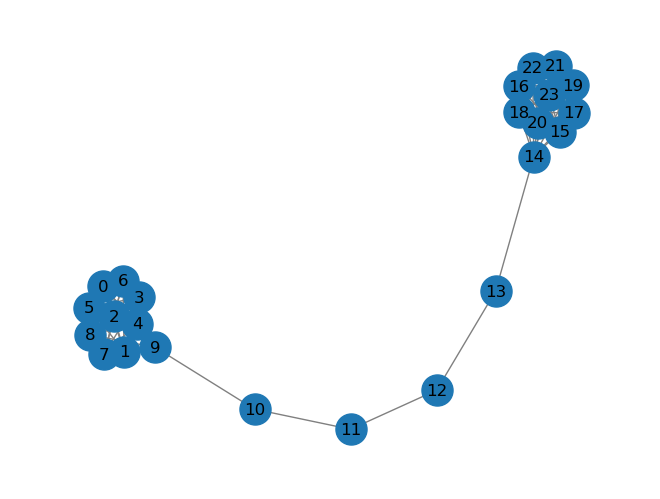

In [14]:
import networkx as nx
from karateclub.node_embedding.neighbourhood.grarep import GraRep

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

gr = GraRep(dimensions=2,order=3)
gr.fit(G)

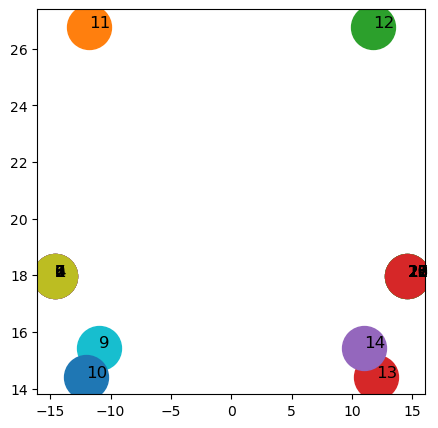

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))
# Since dimensions=2 and order=3, we have 6 dimensions embedded space.
ida = 3
idb = 4
for x in G.nodes():
    
    v = gr.get_embedding()[x]
    ax.scatter(v[ida],v[idb], s=1000)
    ax.annotate(str(x), (v[ida],v[idb]), fontsize=12)

---
## Higher-Order Proximity Preserved Embedding ( HOPE)
HOPE is another graph embedding technique based on the matrix factorization principle.
This method allows preserving higher-order proximity and does not force its embeddings
to have any symmetric properties. 



Given the notion of high-order proximity in graphs, the **HOPE** algorithm is designed to generate node embeddings that preserve these structural relationships, particularly in **directed** graphs where proximity is often asymmetric.

Let the input graph be defined as:

- $G = (V, E)$: a graph with node set $V$ and edge set $E$  
- $A \in \mathbb{R}^{|V| \times |V|}$: the adjacency matrix of $G$

The goal is to approximate a **similarity matrix** $S$ using two separate embedding matrices, one for source nodes and another for target nodes. The optimization objective (loss function) is defined as:

$$
L = \left\| S - Y_s \cdot Y_t^{T} \right\|_F^2
$$

Where:

- $S \in \mathbb{R}^{|V| \times |V|}$ is a similarity matrix derived from graph $G$ that encodes high-order proximity between nodes  
- $Y_s \in \mathbb{R}^{|V| \times d}$: source embedding matrix  
- $Y_t \in \mathbb{R}^{|V| \times d}$: target embedding matrix  
- $d$ is the embedding dimensionality  
- $\|\cdot\|_F$ denotes the Frobenius norm

The use of **separate embeddings for source and target nodes** allows HOPE to effectively capture **asymmetric** relationships in the graph—common in many real-world networks such as citation, hyperlink, or follower graphs.

### Final Embedding Construction

The final embedding of each node is obtained by **concatenating** its source and target embeddings:

$$
Y = [Y_s \,|\, Y_t] \in \mathbb{R}^{|V| \times 2d}
$$

This means each node is ultimately represented in a $2d$-dimensional space.

---

### Similarity Matrix Computation

The similarity matrix $S$ is designed to reflect higher-order proximities between nodes and is computed as:

$$
S = M_g \cdot M_l
$$

where both $M_g$ and $M_l$ are matrix polynomials chosen based on the desired similarity measure. For example, when using the **Adamic-Adar (AA)** similarity measure, we have:

- $M_g = I$ (identity matrix)  
- $M_l = A D A$, where:

  - $A$ is the adjacency matrix  
  - $D$ is a diagonal matrix defined as:

    $$
    D_{ii} = \frac{1}{\sum_j (A_{ij} + A_{ji})}
    $$

This formulation highlights the importance of shared neighbors weighted by node degrees, which is characteristic of the Adamic-Adar method.


### Katz Similarity in HOPE

The **Katz similarity** is a high-order proximity measure used to quantify the relationship between nodes in a graph. It considers **all paths** between two nodes, while giving **shorter paths more weight** than longer ones.

#### 🔸 Mathematical Definition

Given a graph with adjacency matrix \( A \), the Katz similarity matrix \( S \) is defined as:

$
S = \sum_{k=1}^{\infty} \beta^k A^k = \beta A + \beta^2 A^2 + \beta^3 A^3 + \cdots
$

Where:
- $ A^k $: counts the number of paths of length \( k \) between nodes,
- $ \beta \in (0, 1)$: a decay factor that ensures the series converges,
- $ S_{i,j} $: similarity score between node \( i \) and node \( j \).

#### 🔸 Intuition

- The Katz index captures **both direct and indirect relationships** between nodes.
- It assigns higher scores to node pairs that are connected by **many short paths**.
- Longer paths are exponentially down-weighted by the decay factor \( \beta \).

#### 🔸 Role in HOPE

In the HOPE algorithm:
- The **Katz similarity matrix \( S \)** is used to represent node proximities.
- A **generalized SVD** is applied to \( S \) to obtain low-dimensional embeddings.
- The embeddings aim to preserve these high-order proximities in the vector space.

#### 🔸 Choosing $ \beta $

- $ \beta$ must be **small enough** to ensure convergence (i.e., $\beta < \frac{1}{\lambda_{\text{max}}} $, where $ \lambda_{\text{max}} $ is the largest eigenvalue of $ A $).
- A typical value: `beta = 0.01`



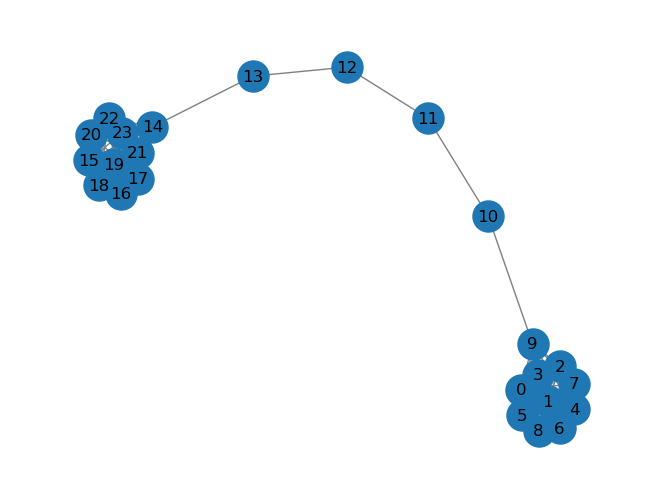

SVD error (low rank): 0.052092


array([[-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07024409, -0.07024348, -0.07024409, -0.07024348],
       [-0.07104037, -0.07104201, -0.07104037, -0.07104201],
       [-0.00797181, -0.00799433, -0.00797181, -0.00799433],
       [-0.00079628, -0.00099787, -0.00079628, -0.00099787],
       [ 0.00079628, -0.00099787,  0.00079628, -0.00099787],
       [ 0.00797181, -0.00799433,  0.00797181, -0.00799433],
       [ 0.07104037, -0.07104201,  0.07104037, -0.07104201],
       [ 0.07024409, -0.07024348,  0.07024409, -0.07024348],
       [ 0.07024409, -0.

In [3]:
import networkx as nx
from gem.embedding.hope import HOPE

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

hp = HOPE(d=4, beta=0.01)
hp.learn_embedding(G)

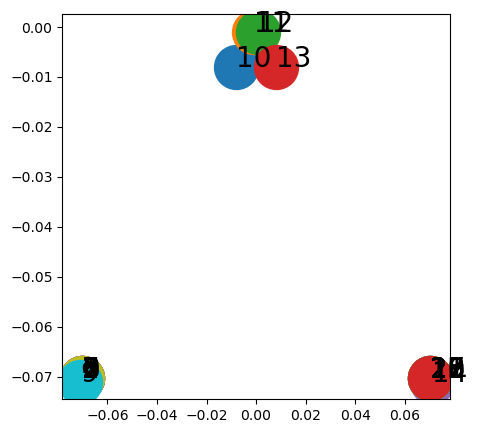

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))

for x in G.nodes():
    
    v = hp.get_embedding()[x,2:]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=20)

In this case, the graph is undirected and thus there is no difference between the source
and target nodes. Figure shows the first two dimensions of the embeddings matrix
representing . It is possible to see how the embedding space generated by HOPE
provides, in this case, a better separation of the different nodes.

---
---
# Skip-Gram Model

The **Skip-Gram** model is a shallow neural network with a single hidden layer, designed to learn vector representations (embeddings) of words based on their context in a corpus. Its primary objective is to predict the surrounding words (context) of a given input word (target).

The training process begins by constructing training samples from a large text corpus. For each word in the corpus, a fixed-size context window of width $ w$ is defined around it. The target word is the central word in the window, and the words within the window are considered its context. For example, for a sentence like:

> “The cat sits on the mat”  
>  
> with $ w = 2 $, the target word “sits” will have the context words: “The”, “cat”, “on”, and “the”.

This process generates multiple (target, context) word pairs, such as (“sits”, “cat”), (“sits”, “on”), etc. These pairs form the basis of the training data.

The Skip-Gram model is then trained to **maximize the probability** of observing a context word given a target word. More formally, for a given target word $ w_t $, the model learns to predict the probability of each context word $ w_{c} $ within the window:

$
P(w_{c} \mid w_{t})
$



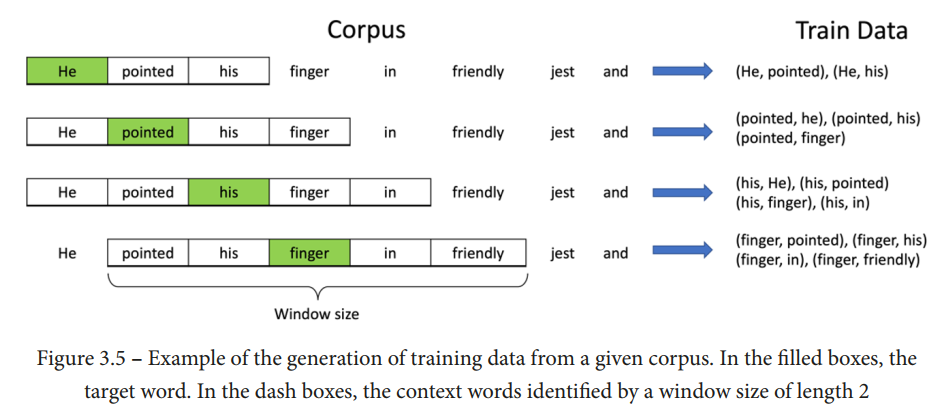

### Model Architecture

The architecture typically consists of:

- **Input layer**: one-hot encoding of the target word.
- **Hidden layer**: a dense layer of size $ d $, where $ d$ is the dimensionality of the word vectors.
- **Output layer**: softmax over the vocabulary to predict context words.

During training, the network learns to map words into a continuous vector space such that semantically similar words are close to each other. This vector space is often referred to as **Word Embedding**, and the entire process is a basis for the **Word2Vec** model, where Skip-Gram is one of the two main architectures (the other being Continuous Bag of Words, or CBOW).

The structure of the neural network representing the skip-gram model is described in the 
following chart:

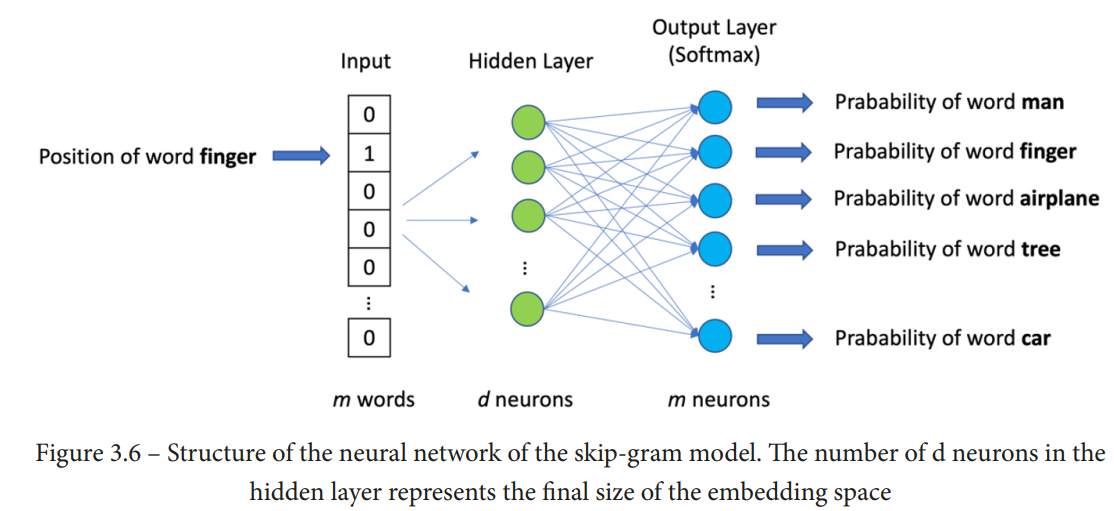

The input of the neural network is a binary vector of size $m$. Each element of the vector represents a word in the dictionary of the language we want to embed the words in. When, during the training process, a (target word, context word) pair is given, the input array will have 0 in all its entries with the exception of the entry representing the "target" word, which will be equal to 1. The hidden layer has d neurons. The hidden layer will learn the embedding representation of each word, creating a d-dimensional embedding space. Finally, the output layer of the neural network is a dense layer of $m$ neurons (the same size as the input vector) with a softmax activation function. Each neuron represents a word of the dictionary. The value assigned by the neuron corresponds to the probability of that word being "related" to the input word. Since softmax can be hard to compute when the 
size of $m$ increases, a hierarchical softmax approach is always used.

The final goal of the skip-gram model is not to actually learn the task we previously described but to build a compact d-dimensional representation of the input words. Thanks to this representation, it is possible to easily extract an embedding space for the words using the weight of the hidden layer. Another common approach to creating a skip-gram model, which will be not described here, is context-based: Continuous Bag-of-Words (CBOW).

When training this neural network, the input is a one-hot encoded vector representing the input word, and the output is also a one-hot encoded vector representing the context word. Remember from the previous image how we constructed input and context pairs of words. Word2vec uses a trick where we aren’t interested in the output vector of the neural network, but rather the goal is to learn the weights of the hidden layer. The weights of the hidden layer are actually the word embedding we are trying to learn. The number of neurons in the hidden layer will determine the embedding dimension or the size of the vector representing each word in the vocabulary.

Note that the neural network does not consider the offset of the context word, so it does not differentiate between directly adjacent context words to the input and those more distant in the context window or even if the context word precedes or follows the input term. Consequently, the window size parameter has a significant influence on the results of the word embedding. For example, a study Dependency-Based Word Embeddings by Levy & Goldberg finds that larger context window size tends to capture more topic/domain information. In contrast, smaller windows tend to capture more information about the word itself, e.g., what other words are functionally similar.

In [5]:
import numpy as np

# Step 1: Define a sample sentence and extract vocabulary
sentence = "the cat sat on the mat"
words = sentence.split()
vocab = sorted(set(words))  # Unique words in the sentence
vocab_size = len(vocab)

# Create word-to-index and index-to-word mappings
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for word, i in word_to_index.items()}

# Step 2: Convert a word to a one-hot encoded vector
def word_to_onehot(word):
    vec = np.zeros(vocab_size)
    vec[word_to_index[word]] = 1
    return vec

# Step 3: Generate skip-gram (input, context) pairs with a sliding window
def generate_skipgram_pairs(words, window_size=2):
    pairs = []
    for center_pos in range(len(words)):
        center_word = words[center_pos]
        # Look at surrounding words within the window
        for w in range(-window_size, window_size + 1):
            context_pos = center_pos + w
            if context_pos < 0 or context_pos >= len(words) or center_pos == context_pos:
                continue
            context_word = words[context_pos]
            pairs.append((center_word, context_word))
    return pairs

# Generate training data
pairs = generate_skipgram_pairs(words, window_size=2)

# Step 4: Print results
print("Vocabulary:", vocab)
print("Word to index mapping:", word_to_index)

print("\nInput-Context pairs (Skip-Gram format):")
for inp, ctx in pairs:
    print(f"({inp}, {ctx})")

print("\nExample one-hot vectors:")
for inp, ctx in pairs[:5]:  # Just show first 5 examples
    print("Input word:", inp, "→", word_to_onehot(inp))
    print("Context word:", ctx, "→", word_to_onehot(ctx))
    print("---")


Vocabulary: ['cat', 'mat', 'on', 'sat', 'the']
Word to index mapping: {'cat': 0, 'mat': 1, 'on': 2, 'sat': 3, 'the': 4}

Input-Context pairs (Skip-Gram format):
(the, cat)
(the, sat)
(cat, the)
(cat, sat)
(cat, on)
(sat, the)
(sat, cat)
(sat, on)
(sat, the)
(on, cat)
(on, sat)
(on, the)
(on, mat)
(the, sat)
(the, on)
(the, mat)
(mat, on)
(mat, the)

Example one-hot vectors:
Input word: the → [0. 0. 0. 0. 1.]
Context word: cat → [1. 0. 0. 0. 0.]
---
Input word: the → [0. 0. 0. 0. 1.]
Context word: sat → [0. 0. 0. 1. 0.]
---
Input word: cat → [1. 0. 0. 0. 0.]
Context word: the → [0. 0. 0. 0. 1.]
---
Input word: cat → [1. 0. 0. 0. 0.]
Context word: sat → [0. 0. 0. 1. 0.]
---
Input word: cat → [1. 0. 0. 0. 0.]
Context word: on → [0. 0. 1. 0. 0.]
---


---
## DeepWalk: Learning Node Embeddings via Random Walks and Skip-Gram

The **DeepWalk** algorithm is a method for learning vector representations (embeddings) of nodes in a graph. It adapts techniques from natural language processing—particularly the **skip-gram model**—to work with graph-structured data.

---

### 🔁 Step 1: Understanding Random Walks

To understand DeepWalk, we first need to define the concept of a **random walk**.

Let \( G \) be a graph and \( v_i \) a node selected as the starting point. From \( v_i \), we randomly choose a neighboring node and move to it. From that node, we repeat the process: randomly select a neighbor and move again. This sequence continues for \( t \) steps, resulting in a **random walk of length \( t \)**.

> Note: There are no constraints on the structure or content of the walk. Therefore, the local neighborhood of a node might not be fully preserved.

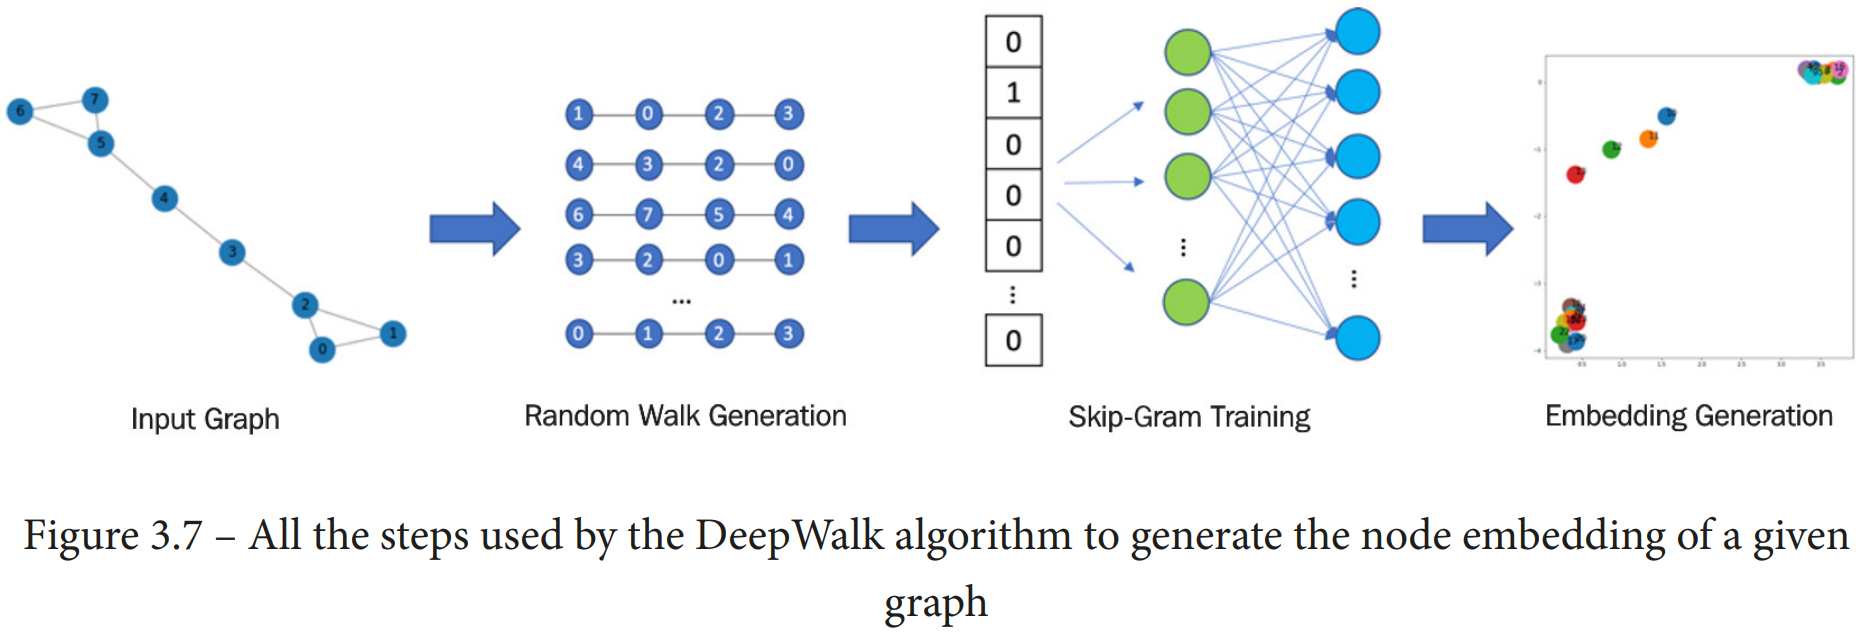

---

### 🧠 Step 2: Applying Skip-Gram to Graph Walks

Once a set of random walks is generated (typically several per node), DeepWalk treats these walks as **sentences**, where each node is like a **word**.

Just like skip-gram learns word embeddings by predicting nearby words, here we learn **node embeddings** by predicting neighboring nodes in the walk.

Key parameters for training:
- **Window size \( w \)**: How many nodes around the target to consider as context
- **Embedding dimension \( d \)**: Size of the vector representation to be learned

---

### 📦 Step 3: Extracting Node Embeddings

Once training is complete, the weights between the input and hidden layer in the skip-gram neural network represent the **node embeddings**.

These embeddings capture structural information from the graph and encode similarities between nodes based on how frequently they co-occur in random walks.

---

### 🧭 Summary of the DeepWalk Algorithm

1. **Random Walk Generation**  
   For each node in the graph, generate multiple random walks of maximum length \( t \).

2. **Skip-Gram Training**  
   Train a skip-gram model using the random walks as input, treating each walk as a sentence and each node as a word.

3. **Embedding Extraction**  
   Use the learned weights of the skip-gram model to extract a low-dimensional vector representation (embedding) for each node.

---

### 📌 Applications

Node embeddings generated by DeepWalk can be used in:
- Node classification
- Community detection
- Link prediction
- Graph visualization



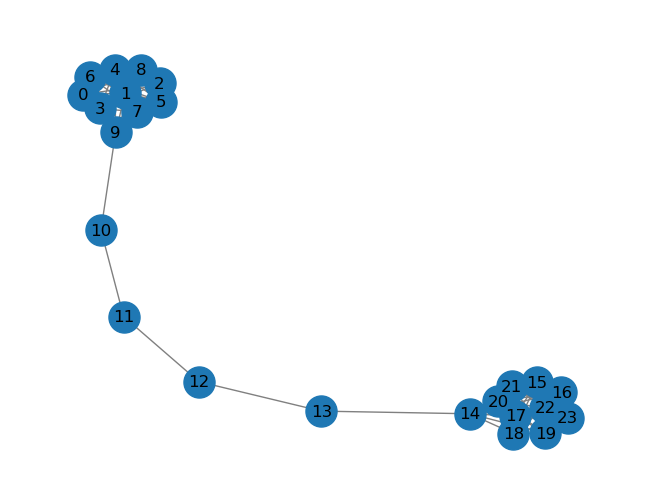

In [7]:
import networkx as nx
from karateclub.node_embedding.neighbourhood.deepwalk import DeepWalk

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

dw = DeepWalk(dimensions=2)
dw.fit(G)

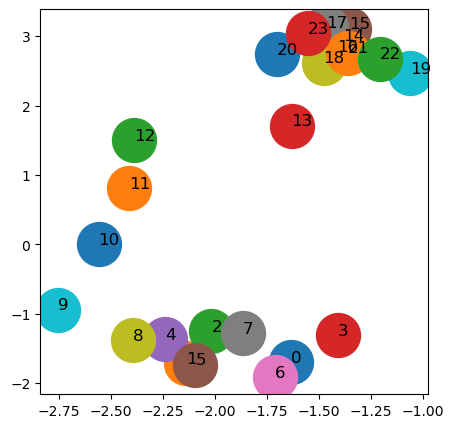

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))

for x in G.nodes():
    
    v = dw.get_embedding()[x]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=12)

---
## Node2Vec
**Node2Vec** is an advanced graph embedding algorithm that builds upon the foundation laid by **DeepWalk**.  
Like DeepWalk, it learns vector representations (embeddings) for nodes by feeding random walks to a **Skip-Gram model with Negative Sampling (SGNS)**. The learned embeddings capture structural roles and node similarities in the graph.

### 🌐 Skip-Gram with Negative Sampling (SGNS)

**SGNS** is a scalable and efficient version of the Skip-Gram model used to learn vector representations (embeddings) for words or nodes.

Instead of using a full softmax over all vocabulary (which is expensive), it uses a simplified objective that only looks at:
- ✅ Positive context pairs (observed together)
- ❌ Negative samples (randomly selected, assumed unrelated)



#### 🔧 Training Strategy

For a given input word (or node) $ w_I $ and a real context word $ w_O $, the model:
- Maximizes the probability of $ w_O $ being in the context of $ w_I $
- Minimizes the probability of $ k $ randomly selected negative words being in the context



#### 🧠 Loss Function

The SGNS loss function is defined as:

$$
\mathcal{L} = -\log \sigma(\mathbf{v}_{w_O}^\top \mathbf{v}_{w_I}) 
- \sum_{i=1}^{k} \log \sigma(-\mathbf{v}_{w_i^-}^\top \mathbf{v}_{w_I})
$$

Where:
- $ \sigma(x) = \frac{1}{1 + e^{-x}} $: Sigmoid function
- $ \mathbf{v}_{w_I} $: Input embedding vector
- $ \mathbf{v}_{w_O} $: Output embedding vector of positive context
- $ w_i^- $: Negative sample drawn from a noise distribution (e.g., unigram distribution raised to 3/4)
- $ k $: Number of negative samples



#### 🚀 Advantages

- ⚡ **Much faster** than full softmax
- 📈 **Scales well** to large vocabularies or graphs
- 🧠 Produces **meaningful embeddings** (semantic or structural similarity)



#### 📌 Used in:
- `word2vec`
- `DeepWalk`
- `node2vec`
- `FastText`




#### 🔑 Key Difference of Node2Vec from DeepWalk

While **DeepWalk** generates random walks using a simple, unbiased strategy (uniformly choosing neighbors), **Node2Vec introduces *biased random walks***.  
These walks blend **Breadth-First Search (BFS)** and **Depth-First Search (DFS)** to control how the graph is explored.

##### 🔄 Biased Random Walks: Exploration vs. Exploitation

Node2Vec uses two parameters, $ p $ and $ q $, to regulate the behavior of the random walk:

- $ \mathbf{p} $: Return parameter  
  Controls the likelihood of revisiting the previous node.  
  - Higher $ p $: encourages staying in the local neighborhood (exploitation)
  - Lower $ p $: more likely to leave the local region

- $\mathbf{q} $: In-out parameter  
  Controls the likelihood of exploring distant or previously unseen nodes.  
  - Lower $ q $: promotes exploring new regions (exploration)
  - Higher $ q $: favors staying nearby

By tuning these parameters, Node2Vec creates **flexible random walks** that strike a balance between:
- 🌍 **Global exploration** of the graph (discovering community structure)
- 🏘️ **Local exploitation** (preserving close neighborhood features)




#### 🧠 How Node2Vec Learns Embeddings

1. **Random Walk Generation**  
   For each node in the graph, Node2Vec generates multiple biased random walks, guided by $ p $ and $ q$.

2. **Skip-Gram Training**  
   These walks are treated like sentences in natural language. Each node is a "word", and the Skip-Gram model (with negative sampling) is trained to predict the context nodes from the walk.

3. **Embedding Extraction**  
   After training, the weights of the hidden layer in the Skip-Gram model become the **vector embeddings** of the nodes.




##### 📊 Example: Embedding Space and Visualization

Suppose we learn **100-dimensional embeddings** for each node in the graph.  
If we reduce these embeddings to 2 dimensions (e.g., using PCA), the relative distances between nodes in this 2D space reflect their true relationships in the original graph.

This way, Node2Vec **preserves both structural proximity and functional similarity** among nodes, even in a lower-dimensional space.

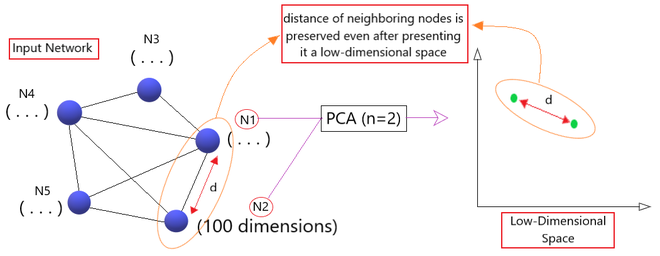



#### 📌 Summary

- ✅ Uses Skip-Gram with Negative Sampling (SGNS)
- 🔄 Introduces **biased** random walks (vs. DeepWalk's uniform ones)
- ⚖️ Parameters $ p $ and $ q $ balance local and global exploration
- 🔍 Preserves both **microscopic** (local) and **macroscopic** (global) graph properties
- 💡 Ideal for tasks like node classification, clustering, and link prediction



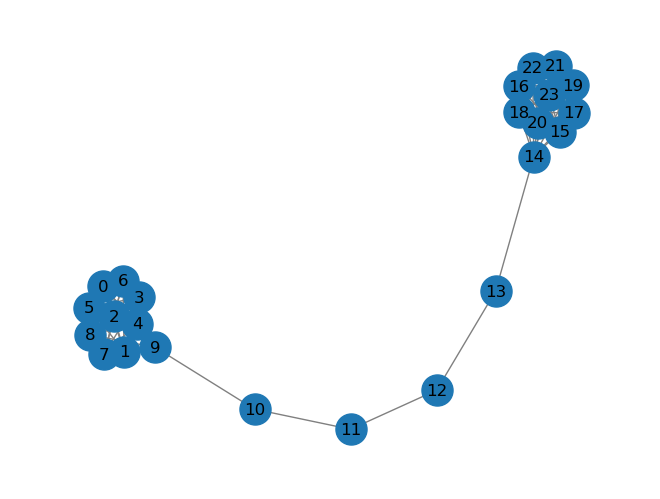

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.19it/s]


In [9]:
import networkx as nx
from node2vec import Node2Vec

G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

node2vec = Node2Vec(G, dimensions=2)
model = node2vec.fit(window=10)
embeddings = model.wv

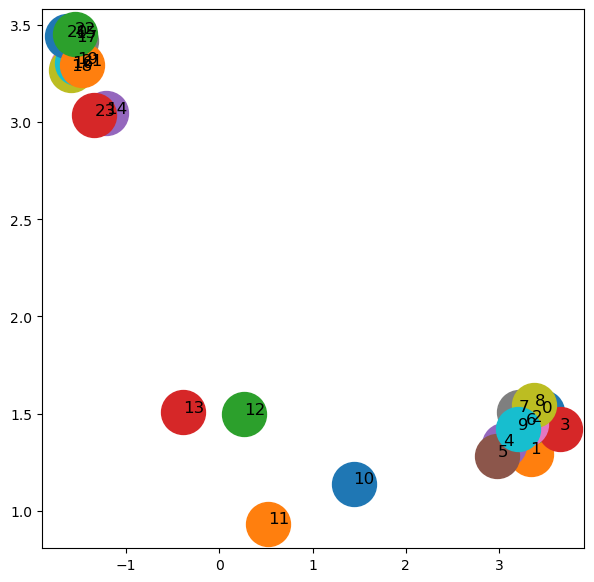

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,7))

for x in G.nodes():
    
    v = model.wv[str(x)]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=12)

plt.show()

In [33]:
print(model.wv["1"])

[-2.8825765  1.814908 ]


## Edge2Vec: Learning Edge Representations from Node Embeddings

Unlike most graph embedding methods that focus on learning representations for **nodes**,  
**Edge2Vec** is a simple yet effective approach designed to generate embeddings for **edges** in a graph.



### 💡 Core Idea

Edge2Vec builds upon the embeddings learned by algorithms like **Node2Vec**.  
Rather than training a new model from scratch, it derives the embedding of an edge based on the embeddings of the two nodes it connects.

Let:
- $v_i $ and $v_j$ be two **adjacent nodes** in the graph.
- $ f(v_i) $ and $ f(v_j) $ be the **node embeddings** obtained from Node2Vec (or similar methods).

Then, the **edge embedding** $ f(v_i, v_j) $ can be computed using **simple mathematical operations** between $ f(v_i) $ and $ f(v_j) $.



### 🧮 Common Edge Embedding Operators

Here are some typical operators used to compute the edge representation:

| Operator         | Formula                                  | Description                          |
|------------------|-------------------------------------------|--------------------------------------|
| Hadamard Product | $ f(v_i, v_j) = f(v_i) \cdot f(v_j) $   | Element-wise product                 |
| Average          | $ f(v_i, v_j) = \frac{f(v_i) + f(v_j)}{2} $ | Element-wise average                 |
| Weighted L1      | $ f(v_i, v_j) = |f(v_i) - f(v_j)|$     | Absolute difference                  |
| Weighted L2      | $ f(v_i, v_j) = (f(v_i) - f(v_j))^2 $    | Squared difference (element-wise)    |



### 🧠 Intuition

- These operations encode the **interaction** or **relationship** between the connected nodes.
- Once node embeddings are available, edge embeddings can be computed **without retraining** a new model.
- These edge representations are useful for tasks such as:
  - **Link prediction**
  - **Edge classification**
  - **Similarity computation** between relationships



### ✅ Summary

- **Edge2Vec** is not a separate model, but a **post-processing step** on top of Node2Vec (or similar).
- It enables transforming node-level embeddings into **edge-level representations**.
- It relies on simple and efficient vector operations that are easy to compute and interpret.



In [11]:
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

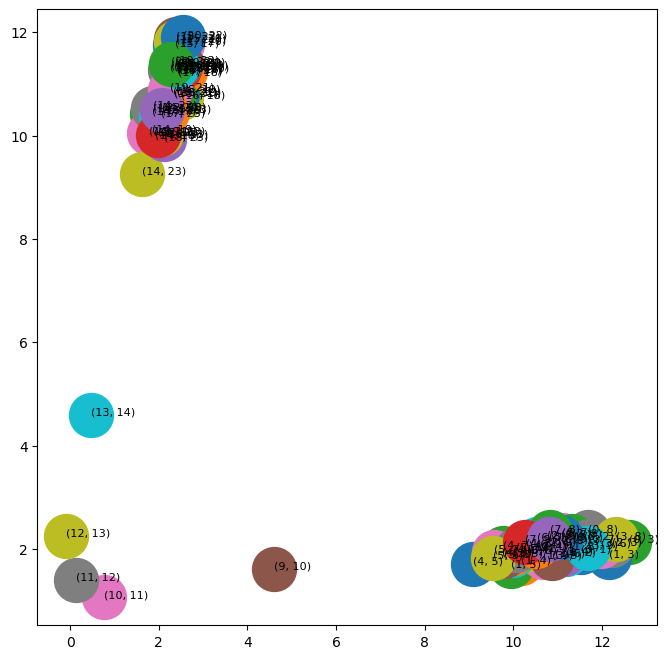

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))

for x in G.edges():
    
    v = edges_embs[(str(x[0]), str(x[1]))]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=8)

plt.show()

##  Graph2Vec: Learning Vector Representations of Entire Graphs

While previous methods such as Node2Vec and Edge2Vec focus on learning embeddings for **individual nodes** or **edges**,  
**Graph2Vec** extends this idea by generating a single embedding for the **entire graph**.



### 📦 Objective

Given a **collection of graphs**, Graph2Vec learns a vector space where **each point corresponds to one graph**.  
This is especially useful for tasks like:
- Graph classification  
- Graph similarity search  
- Graph clustering  



### 🧩 Underlying Concept

Graph2Vec adapts the principles of **Word2Vec** and **Doc2Vec** (used in NLP) to graph structures.

- A **graph** is treated like a **document**.
- **Subgraphs** (usually ego-nets centered around each node) are treated as **words**.
- Just as Doc2Vec learns embeddings for entire documents based on the words they contain,  
  Graph2Vec learns embeddings for entire graphs based on their substructures.



### 🪜 Algorithm Steps

1. ### 🔍 Subgraph Generation  
   For each graph $G$ in the dataset:
   - Generate a set of **rooted subgraphs** (e.g., **ego-graphs**) centered on each node.
   - These subgraphs act like "words" for that "graph document".

2. ### 🧠 Doc2Vec Training  
   - Treat each graph as a "document" and its subgraphs as "words".
   - Train a **Doc2Vec** model using these synthetic documents.
   - The model tries to **predict subgraphs (contexts)** given a graph and learn useful representations.

3. ### 🔢 Embedding Generation  
   - Once training is complete, the **hidden representation** associated with each document (graph) is extracted.
   - This becomes the **graph-level embedding** $ f(G) \in \mathbb{R}^d$, where $ d $ is the embedding dimension.

---

### 📌 Summary

- **Graph2Vec** allows us to represent **entire graphs** in a continuous vector space.  
- It is based on the idea of using **subgraph structures as building blocks**, much like words in a document.
- Inspired by NLP techniques, it provides a flexible and unsupervised way to learn graph-level embeddings suitable for downstream tasks.



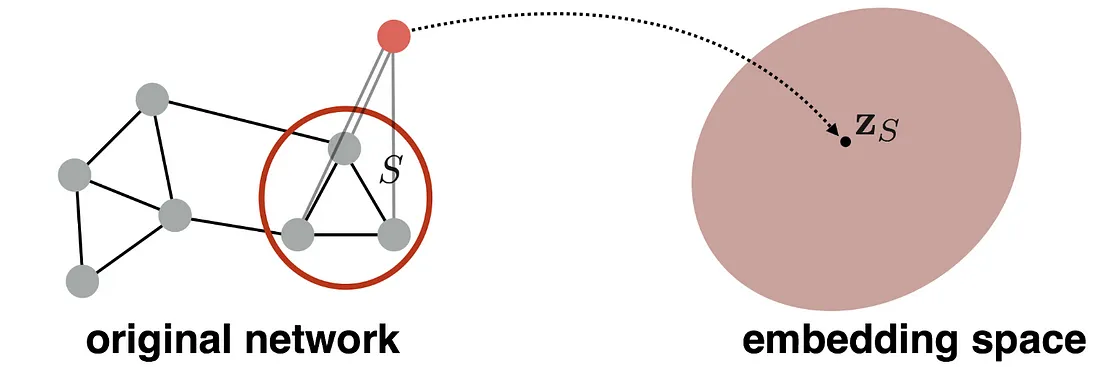


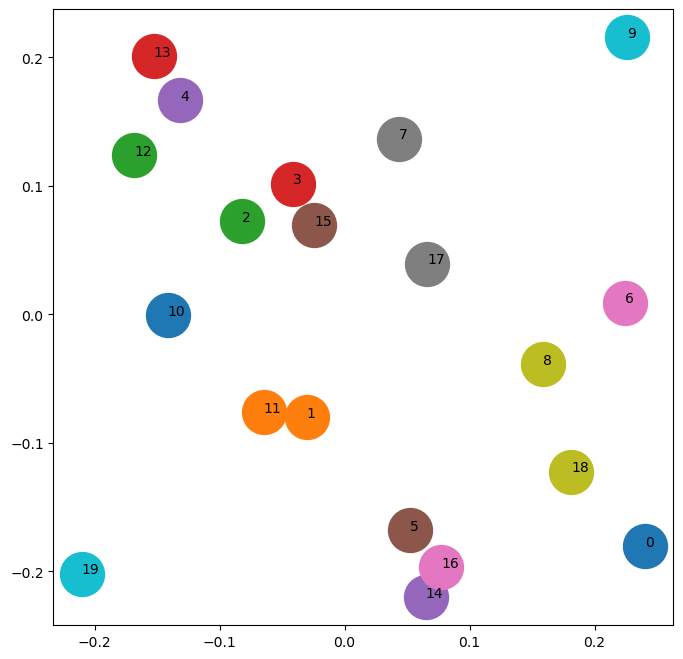

In [14]:
import random
import matplotlib.pyplot as plt
from karateclub import Graph2Vec

n_graphs = 20

def generate_radom():
    n = random.randint(6, 20)
    k = random.randint(5, n)
    p = random.uniform(0, 1)
    return nx.watts_strogatz_graph(n,k,p), [n,k,p]

Gs = [generate_radom() for x in range(n_graphs)]

model = Graph2Vec(dimensions=2, wl_iterations=10)
model.fit([x[0] for x in Gs])
embeddings = model.get_embedding()

fig, ax = plt.subplots(figsize=(8,8))

for i,vec in enumerate(embeddings):
    
    ax.scatter(vec[0],vec[1], s=1000)
    ax.annotate(str(i), (vec[0],vec[1]), fontsize=10)